# Continuous Verification Results Analysis

This notebook summarizes the per-step CSV outputs (e.g., `results/step_00.csv`, `results/step_01.csv`, ...), computes a few aggregate stats, and plots trends as we progressively average anchors.

In [1]:
from __future__ import annotations

import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Adjust these if your results are elsewhere
RESULTS_DIR = Path("results")
STEP_GLOB = str(RESULTS_DIR / "step_*.csv")

plt.style.use("seaborn-v0_8")



In [2]:
# Load all step CSVs
csv_paths = sorted(Path(p) for p in glob.glob(STEP_GLOB))
if not csv_paths:
    raise FileNotFoundError(f"No step_*.csv found under {RESULTS_DIR}")

frames = []
for p in csv_paths:
    df = pd.read_csv(p)
    # derive step number from filename
    step_str = p.stem.split("_")[-1]
    try:
        step = int(step_str)
    except ValueError:
        step = None
    df["step"] = step
    frames.append(df)

all_df = pd.concat(frames, ignore_index=True)
print(f"Loaded {len(csv_paths)} CSVs, {len(all_df)} rows total")
all_df.head()



Loaded 10 CSVs, 90 rows total


,verify_video,status,embed_code,cosine_distance,euclidean,l2_euclidean,votes_passed,match_code,error,anchor_desc,anchor_size,step
0,data\verify\1a3a2365-e455-4bc1-99cf-4977d2e8f5...,ok,0,0.374992,1.108884,0.866016,3,0,NaN,onboard,1,0
1,data\verify\513c1695-d0a3-4eab-93d4-8dc0edd660...,ok,0,0.244947,0.904280,0.699924,3,0,NaN,onboard,1,0
2,data\verify\5b9b29a8-26be-4d43-a165-8eec4443d5...,ok,0,0.437552,1.140290,0.935470,3,0,NaN,onboard,1,0
3,data\verify\99a0cd56-992e-49de-a0a5-3621a2b00a...,ok,0,0.331048,1.020860,0.813693,3,0,NaN,onboard,1,0
4,data\verify\b0aa040b-8e15-46ca-8e41-f684cab2d0...,ok,0,0.219203,0.826428,0.662122,3,0,NaN,onboard,1,0


In [3]:
# Basic cleaning / typing

# Ensure match_code is numeric when present
if all_df["match_code"].dtype == object:
    all_df["match_code_num"] = pd.to_numeric(all_df["match_code"], errors="coerce")
else:
    all_df["match_code_num"] = all_df["match_code"]

# Flag rows with successful embeddings
all_df["embed_ok"] = all_df["embed_code"].fillna(0).astype(int).eq(0)

# Rows that were compared successfully
all_df["comp_ok"] = all_df["status"].eq("ok")

all_df.head()



,verify_video,status,embed_code,cosine_distance,euclidean,l2_euclidean,votes_passed,match_code,error,anchor_desc,anchor_size,step,match_code_num,embed_ok,comp_ok
0,data\verify\1a3a2365-e455-4bc1-99cf-4977d2e8f5...,ok,0,0.374992,1.108884,0.866016,3,0,NaN,onboard,1,0,0,True,True
1,data\verify\513c1695-d0a3-4eab-93d4-8dc0edd660...,ok,0,0.244947,0.904280,0.699924,3,0,NaN,onboard,1,0,0,True,True
2,data\verify\5b9b29a8-26be-4d43-a165-8eec4443d5...,ok,0,0.437552,1.140290,0.935470,3,0,NaN,onboard,1,0,0,True,True
3,data\verify\99a0cd56-992e-49de-a0a5-3621a2b00a...,ok,0,0.331048,1.020860,0.813693,3,0,NaN,onboard,1,0,0,True,True
4,data\verify\b0aa040b-8e15-46ca-8e41-f684cab2d0...,ok,0,0.219203,0.826428,0.662122,3,0,NaN,onboard,1,0,0,True,True


In [4]:
# Aggregate metrics per step
agg = (
    all_df
    .groupby("step")
    .agg(
        rows=("verify_video", "count"),
        embed_failures=("embed_ok", lambda x: (~x).sum()),
        comparisons=("comp_ok", "sum"),
        match_rate=("match_code_num", lambda x: 1 - x.mean(skipna=True) if len(x.dropna()) else float("nan")),
        mean_cosine=("cosine_distance", "mean"),
        mean_euclidean=("euclidean", "mean"),
        mean_l2_euclidean=("l2_euclidean", "mean"),
    )
    .reset_index()
)

agg



,step,rows,embed_failures,comparisons,match_rate,mean_cosine,mean_euclidean,mean_l2_euclidean
0,0,9,0,9,1.0,0.329452,1.028213,0.806307
1,1,9,0,9,1.0,0.203487,0.798401,0.629631
2,2,9,0,9,1.0,0.186304,0.762436,0.598838
3,3,9,0,9,1.0,0.155578,0.707014,0.553597
4,4,9,0,9,1.0,0.143294,0.682142,0.532243
5,5,9,0,9,1.0,0.142737,0.679124,0.529606
6,6,9,0,9,1.0,0.138314,0.668237,0.520355
7,7,9,0,9,1.0,0.129677,0.651624,0.506554
8,8,9,0,9,1.0,0.125810,0.642980,0.499319
9,9,9,0,9,1.0,0.123687,0.636735,0.494088


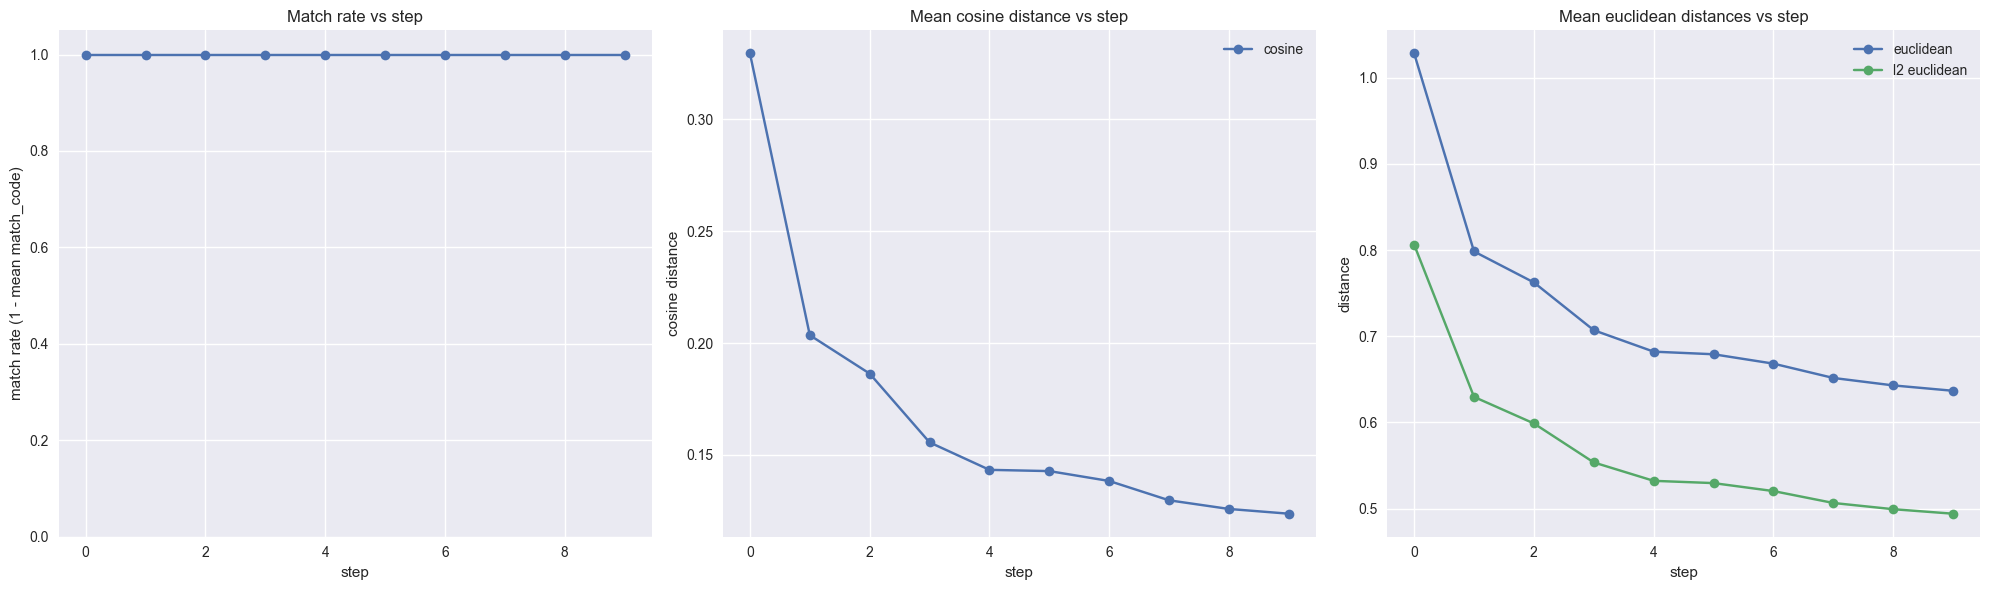

In [11]:
# Plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(agg["step"], agg["match_rate"], marker="o")
axes[0].set_title("Match rate vs step")
axes[0].set_xlabel("step")
axes[0].set_ylabel("match rate (1 - mean match_code)")
axes[0].set_ylim(0, 1.05)

axes[1].plot(agg["step"], agg["mean_cosine"], marker="o", label="cosine")
axes[1].set_title("Mean cosine distance vs step")
axes[1].set_xlabel("step")
axes[1].set_ylabel("cosine distance")
axes[1].legend()

axes[2].plot(agg["step"], agg["mean_euclidean"], marker="o", label="euclidean")
axes[2].plot(agg["step"], agg["mean_l2_euclidean"], marker="o", label="l2 euclidean")
axes[2].set_title("Mean euclidean distances vs step")
axes[2].set_xlabel("step")
axes[2].set_ylabel("distance")
axes[2].legend()

fig.tight_layout()
# fig



## Per-video trajectories (one-to-one)
For each step, this shows distances to every verify file individually (no averaging on the comparison side), so you can see how each cumulative anchor affects the remaining videos.


In [7]:
# Pivot per verify file across steps (only successful comparisons)
per_video = all_df[all_df["comp_ok"]].copy()

cosine_pivot = per_video.pivot_table(index="step", columns="verify_video", values="cosine_distance")
euclid_pivot = per_video.pivot_table(index="step", columns="verify_video", values="euclidean")
l2_pivot = per_video.pivot_table(index="step", columns="verify_video", values="l2_euclidean")
match_pivot = per_video.pivot_table(index="step", columns="verify_video", values="match_code_num")

# Step-to-step change after each merge
cosine_delta = cosine_pivot.diff()
match_delta = match_pivot.diff()

cosine_pivot.head()


verify_video,data\verify\1a3a2365-e455-4bc1-99cf-4977d2e8f5b3.mp4,data\verify\513c1695-d0a3-4eab-93d4-8dc0edd660df.mp4,data\verify\5b9b29a8-26be-4d43-a165-8eec4443d58c.mp4,data\verify\99a0cd56-992e-49de-a0a5-3621a2b00a71.mp4,data\verify\b0aa040b-8e15-46ca-8e41-f684cab2d0ac.mp4,data\verify\ca7866a0-09d3-4183-bd24-1c38f4668dcc.mp4,data\verify\d602b324-a845-43b3-81b8-13be6333d5b0.mp4,data\verify\dba276a4-2736-49ec-8318-0c0c4e23b324.mp4,data\verify\e17a960b-0a78-44a5-9762-d119e10186d3.mp4
step,,,,,,,,,
0,0.374992,0.244947,0.437552,0.331048,0.219203,0.242453,0.420391,0.363853,0.330634
1,0.088180,0.200164,0.298453,0.215480,0.183253,0.139549,0.278631,0.243599,0.184075
2,0.128361,0.082223,0.298207,0.202219,0.124197,0.132828,0.278108,0.243744,0.186846
3,0.122253,0.109478,0.170948,0.159028,0.137156,0.115504,0.231409,0.206400,0.148022
4,0.128354,0.123949,0.160134,0.097522,0.144407,0.116678,0.203695,0.180498,0.134411


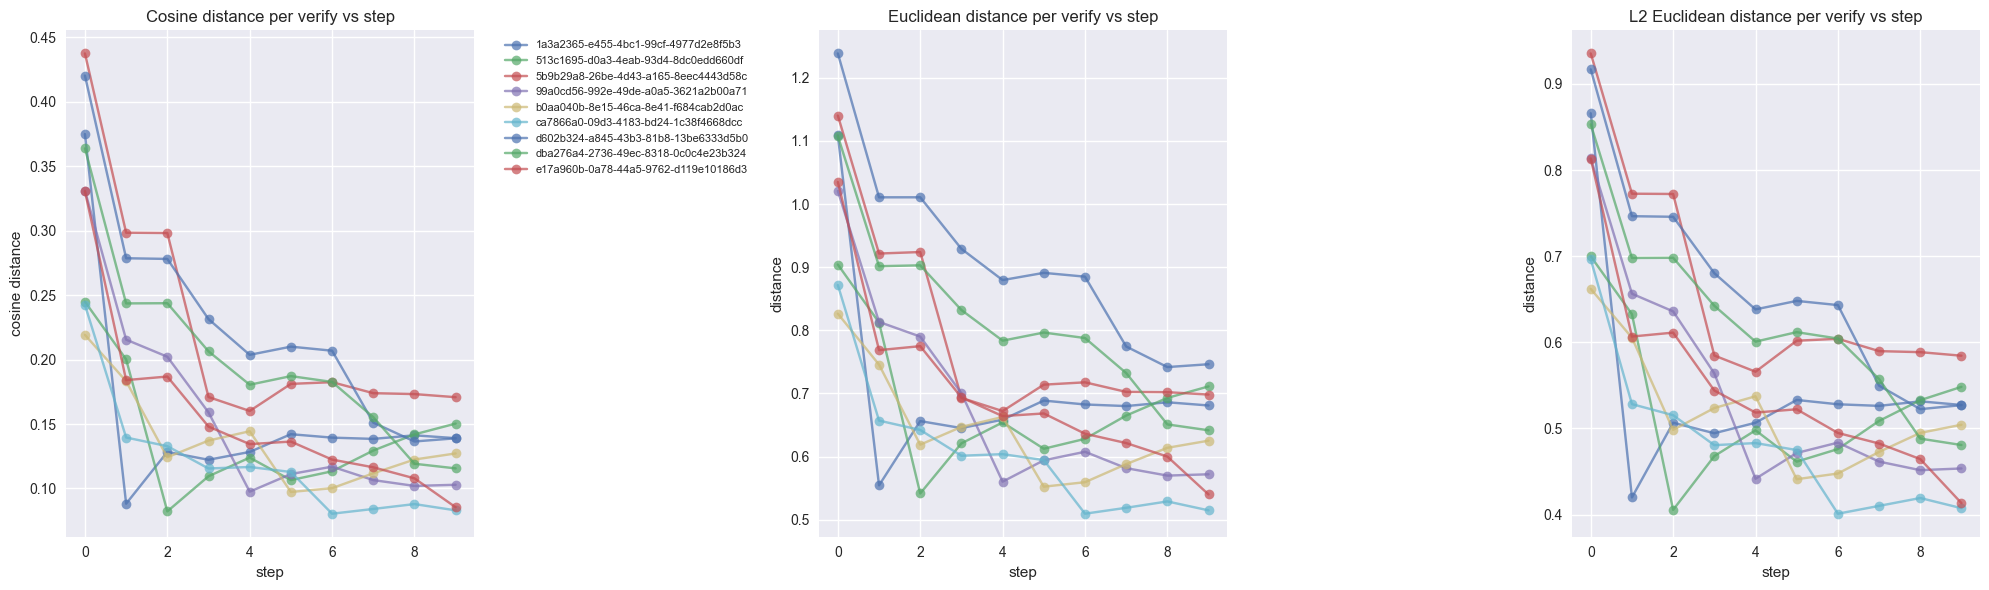

In [10]:
# Plot trajectories per verify file
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

for col in cosine_pivot.columns:
    axes[0].plot(cosine_pivot.index, cosine_pivot[col], marker="o", alpha=0.7, label=Path(col).stem)
axes[0].set_title("Cosine distance per verify vs step")
axes[0].set_xlabel("step")
axes[0].set_ylabel("cosine distance")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

for col in euclid_pivot.columns:
    axes[1].plot(euclid_pivot.index, euclid_pivot[col], marker="o", alpha=0.7, label=Path(col).stem)
axes[1].set_title("Euclidean distance per verify vs step")
axes[1].set_xlabel("step")
axes[1].set_ylabel("distance")

for col in l2_pivot.columns:
    axes[2].plot(l2_pivot.index, l2_pivot[col], marker="o", alpha=0.7, label=Path(col).stem)
axes[2].set_title("L2 Euclidean distance per verify vs step")
axes[2].set_xlabel("step")
axes[2].set_ylabel("distance")

fig.tight_layout()
# fig


In [ ]:
# Optional: per-step change (delta) table for cosine distances
# This highlights how adding each verify affects distances to every verify file.
cosine_delta.head()



## 2D face map (initial onboarding vs verify videos)
This uses `result.csv` (initial onboarding anchor) to place thumbnails on a 2D plane: x = cosine distance, y = L2 Euclidean distance. The onboarding frame is placed at (0,0); each verify video is placed at its (cosine_distance, l2_euclidean).


Loaded 9 rows from result.csv


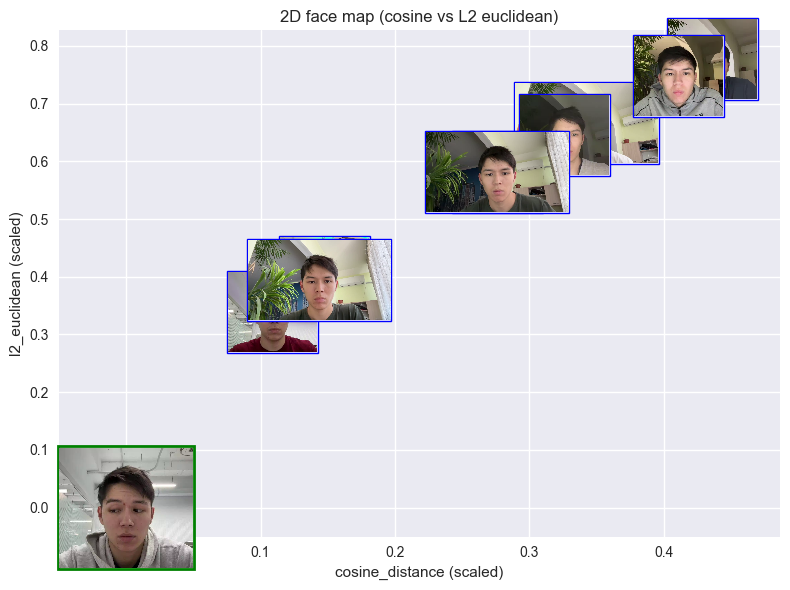

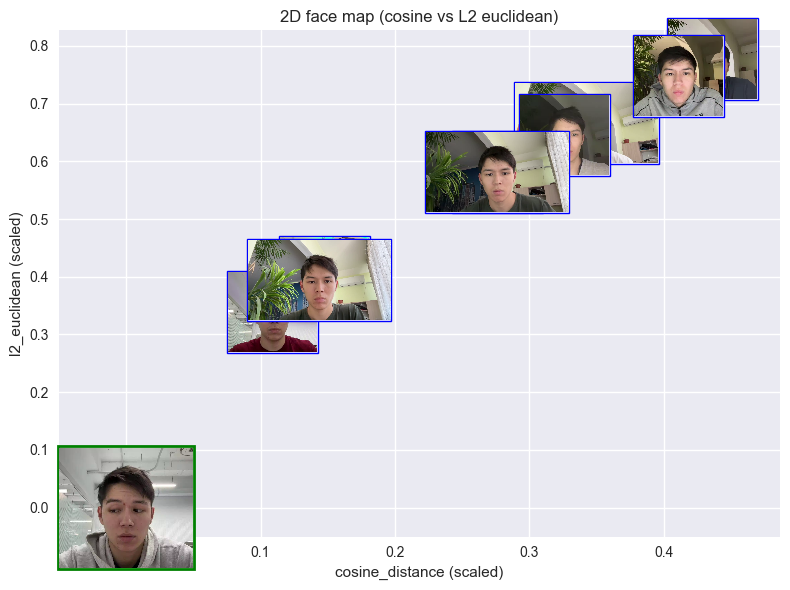

In [14]:
import cv2
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Paths
RESULT_SINGLE = Path("result.csv")
ONBOARD_VIDEO = Path("data/onboard/video.mp4")
VERIFY_ROOT = Path("data/verify")

# Load result.csv
single_df = pd.read_csv(RESULT_SINGLE)
print(f"Loaded {len(single_df)} rows from {RESULT_SINGLE}")


def _first_frame_bgr(video_path: Path) -> np.ndarray:
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")
    try:
        for _ in range(30):
            ok, frame = cap.read()
            if ok and frame is not None:
                return frame
        raise RuntimeError(f"Could not read first frame from video: {video_path}")
    finally:
        cap.release()


def _bgr_to_rgb(frame_bgr: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)


# Extract thumbnails
thumbs = {}
try:
    onboard_frame = _bgr_to_rgb(_first_frame_bgr(ONBOARD_VIDEO))
    thumbs["onboard"] = onboard_frame
except Exception as e:
    print(f"[warn] onboard frame extraction failed: {e}")

for _, row in single_df.iterrows():
    vpath = Path(row["verify_video"])
    key = vpath.stem
    if key in thumbs:
        continue
    try:
        frame = _bgr_to_rgb(_first_frame_bgr(vpath))
        thumbs[key] = frame
    except Exception as e:
        print(f"[warn] verify frame extraction failed for {vpath}: {e}")

# Plot with nonlinear scaling to emphasize higher distances
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("2D face map (cosine vs L2 euclidean)")
ax.set_xlabel("cosine_distance (scaled)")
ax.set_ylabel("l2_euclidean (scaled)")

# Helper scaling: piecewise stretch
# Cosine: 0-0.2 compressed, 0.2-0.5 stretched
c_x = single_df["cosine_distance"].to_numpy()
c_x_scaled = np.where(c_x <= 0.2, c_x * 0.4, 0.08 + (c_x - 0.2) * 1.5)

# L2: 0-0.6 compressed, 0.6-1.1 stretched
c_y = single_df["l2_euclidean"].to_numpy()
c_y_scaled = np.where(c_y <= 0.6, c_y * 0.4, 0.24 + (c_y - 0.6) * 1.6)

# Scatter points (tiny markers behind thumbnails for visibility)
ax.scatter(c_x_scaled, c_y_scaled, c="C0", alpha=0.15, s=8)

# Add onboarding at origin (slightly larger, with border)
if "onboard" in thumbs:
    oi = OffsetImage(thumbs["onboard"], zoom=0.12)
    ab = AnnotationBbox(oi, (0, 0), frameon=True, pad=0.12, bboxprops={"edgecolor": "green", "linewidth": 2})
    ax.add_artist(ab)

# Add verify thumbnails (smaller, no text label)
for idx, row in single_df.iterrows():
    vpath = Path(row["verify_video"])
    key = vpath.stem
    x = c_x_scaled[idx]
    y = c_y_scaled[idx]
    if key in thumbs:
        img = thumbs[key]
        zoom = 0.08  # smaller to reduce overlap
        oi = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(oi, (x, y), frameon=True, pad=0.08, bboxprops={"edgecolor": "blue", "linewidth": 1})
        ax.add_artist(ab)
    else:
        ax.scatter([x], [y], c="red", marker="x")

# Nice bounds (scaled space)
x_min = min(0, c_x_scaled.min()) - 0.05
x_max = c_x_scaled.max() + 0.05
y_min = min(0, c_y_scaled.min()) - 0.05
y_max = c_y_scaled.max() + 0.05
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
fig


In [12]:
# Detailed per-step breakdown (optional display)
display_cols = [
    "step",
    "verify_video",
    "status",
    "embed_code",
    "cosine_distance",
    "euclidean",
    "l2_euclidean",
    "votes_passed",
    "match_code",
    "anchor_desc",
    "anchor_size",
]

all_df[display_cols].sort_values(["step", "verify_video"]).head(20)



,step,verify_video,status,embed_code,cosine_distance,euclidean,l2_euclidean,votes_passed,match_code,anchor_desc,anchor_size
0,0,data\verify\1a3a2365-e455-4bc1-99cf-4977d2e8f5...,ok,0,0.374992,1.108884,0.866016,3,0,onboard,1
1,0,data\verify\513c1695-d0a3-4eab-93d4-8dc0edd660...,ok,0,0.244947,0.904280,0.699924,3,0,onboard,1
2,0,data\verify\5b9b29a8-26be-4d43-a165-8eec4443d5...,ok,0,0.437552,1.140290,0.935470,3,0,onboard,1
3,0,data\verify\99a0cd56-992e-49de-a0a5-3621a2b00a...,ok,0,0.331048,1.020860,0.813693,3,0,onboard,1
4,0,data\verify\b0aa040b-8e15-46ca-8e41-f684cab2d0...,ok,0,0.219203,0.826428,0.662122,3,0,onboard,1
5,0,data\verify\ca7866a0-09d3-4183-bd24-1c38f4668d...,ok,0,0.242453,0.871764,0.696352,3,0,onboard,1
6,0,data\verify\d602b324-a845-43b3-81b8-13be6333d5...,ok,0,0.420391,1.238672,0.916942,3,0,onboard,1
7,0,data\verify\dba276a4-2736-49ec-8318-0c0c4e23b3...,ok,0,0.363853,1.107757,0.853056,3,0,onboard,1
8,0,data\verify\e17a960b-0a78-44a5-9762-d119e10186...,ok,0,0.330634,1.034980,0.813184,3,0,onboard,1
9,1,data\verify\1a3a2365-e455-4bc1-99cf-4977d2e8f5...,ok,0,0.088180,0.554442,0.419951,3,0,onboard+first_1_verify,2


## Notes
- `match_rate` here is computed as `1 - mean(match_code)` where `match_code` follows the service convention (0 = match/success, 1 = mismatch). Lower distances and higher match_rate are better.
- Each CSV is read as-is; failures to embed stay marked as `embed_failed` and are counted in `embed_failures`.
- If you rerun with different frame selection or thresholds, update the CSVs then re-run this notebook.

